# 第3章 ネットワークの性質を知る

## 分析の準備

### 必要なライブラリのインストール

In [1]:
!pip install networkx
!pip install torch_geometric

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx, to_networkx

### データセットの読み込み
ここでは、`torch_geometric`のPlanetoidデータセットのうちPubMedを使用し、`networkx`形式に変換して解析を行います

In [3]:
# データセットの読み込み
dataset = Planetoid(root=".", name="PubMed")
G = to_networkx(dataset.data, to_undirected=True)

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### ネットワークの可視化
ネットワークの全体像を把握するために描画を行います。大きなネットワークであるため、描画に時間がかかることに注意が必要です。

In [4]:
# ネットワークの描画。時間がかかる
# nx.draw(G, node_size=2, width=.1)

## ネットワーク全体の概形をみる
ノード数（ネットワークの大きさ）、エッジ数、密度などを算出することで、ネットワークの基本的な特徴を確認します。

In [5]:
# |V|
# len(G)でも同じ結果が得られる
print("ノードの数（ネットワークの大きさ）: ", G.number_of_nodes())

# |E|
print("エッジの数: ", G.number_of_edges())

# 密度
print("ネットワークの密度: ", nx.density(G))
# 愚直に計算する場合
print(
    "ネットワークの密度: ",
    G.number_of_edges() * 2 / (G.number_of_nodes() * (G.number_of_nodes() - 1)),
)

# 直径
# 全てのノード間で最短経路を算出するため時間がかかる
# print("ネットワークの直径: ", nx.diameter(G))

ノードの数（ネットワークの大きさ）:  19717
エッジの数:  44324
ネットワークの密度:  0.00022803908825811382
ネットワークの密度:  0.00022803908825811382


また、連結したネットワークを抽出したい場合は以下のような操作が有用です。

In [6]:
# 連結しているかどうかかどうかの判別
print("連結しているか: ", nx.is_connected(G))

# 連結成分の数の算出
print("連結成分の数: ", nx.number_connected_components(G))

# 各連結成分を構成するノード集合
components = nx.connected_components(G)
# 最大連結成分のノード集合を取得
nodes_largest_component = max(components, key=len)
# 最大連結成分を部分グラフとして取得
subg = G.subgraph(nodes_largest_component).copy()

print("最大連結成分の大きさ: ", len(subg))

連結しているか:  True
連結成分の数:  1
最大連結成分の大きさ:  19717


## どのようなノードか

### 中心性指標
最も基本的な中心性指標である次数中心性を算出し、扱い易い形式へと変換する操作を紹介します。

In [7]:
# 次数中心性
degree_c = G.degree()
# print(degree_c)

# 辞書形式への変換
dict_degree = dict(degree_c)
# print(dict_degree)

# リスト形式への変換
li_degree = list(dict_degree.values())
# print(li_degree)

# DataFrameオブジェクトの形に整理
df_degree = pd.DataFrame(list(degree_c), columns=["node_id", "degree"])

print(df_degree.head())

   node_id  degree
0        0       5
1        1       3
2        2       3
3        3       1
4        4       1


その他の基本的な中心性についても算出します。

In [8]:
# 固有ベクトル中心性
eigen_c = nx.eigenvector_centrality(G)
# 先頭10ノードについて、求めた固有ベクトル中心性を表示
print(list(eigen_c.items())[0:10])

# 近接中心性
# 計算に時間がかかるためコメントアウトしている
# closeness_c = nx.closeness_centrality(G)

# 媒介中心性
# 計算に時間がかかるためコメントアウトしている
# betweenness_c = nx.betweenness_centrality(G)

# ページランク
pagerank_c = nx.pagerank(G, alpha=0.85)

# 局所クラスター係数
local_clustering = nx.clustering(G)

[(0, 0.00023434854228360225), (1, 1.961610489750726e-06), (2, 2.4244205161309935e-05), (3, 0.00024243768339282228), (4, 3.744676658921824e-07), (5, 0.00023448359061203593), (6, 0.02154640900674408), (7, 0.00013234787968180467), (8, 3.291732420569048e-05), (9, 3.6524288458446106e-05)]


複数の中心性について、相関係数行列と要約統計量を求めます。

In [9]:
# 中心性の相関係数と、統計量
df_centrality = pd.DataFrame(
    {
        "degree": li_degree,
        "eigen": dict(eigen_c).values(),
        "pagerank": dict(pagerank_c).values(),
# 上のセルで算出していないためコメントアウト
#         "closeness": dict(closeness_c).values(),
#         "betweenness": dict(betweenness_c).values(),
        "local_clustering": dict(local_clustering).values(),
    }
)
print("中心性の相関係数行列: \n", df_centrality.corr().round(2))
print("中心性の要約統計量: \n", df_centrality.describe().round(3))

中心性の相関係数行列: 
                   degree  eigen  pagerank  local_clustering
degree              1.00   0.51      0.93              0.04
eigen               0.51   1.00      0.27              0.04
pagerank            0.93   0.27      1.00              0.00
local_clustering    0.04   0.04      0.00              1.00
中心性の要約統計量: 
           degree      eigen   pagerank  local_clustering
count  19717.000  19717.000  19717.000         19717.000
mean       4.496      0.001      0.000             0.060
std        7.431      0.007      0.000             0.182
min        1.000      0.000      0.000             0.000
25%        1.000      0.000      0.000             0.000
50%        2.000      0.000      0.000             0.000
75%        4.000      0.000      0.000             0.000
max      171.000      0.172      0.002             1.000


### 中心性指標の分布

算出した中心性について、その分布を見ることで、ネットワークについての理解をより深めることができます。

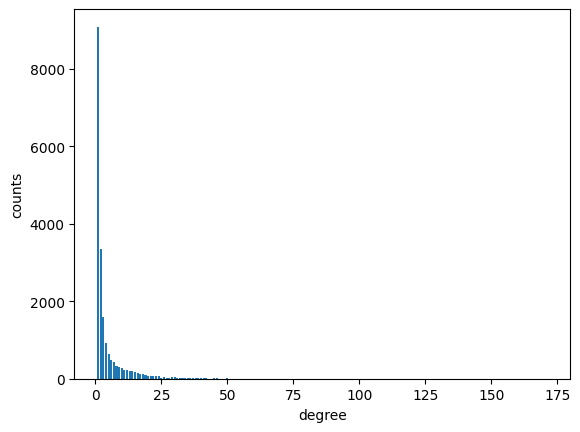

In [10]:
# 棒グラフ
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.xlabel("degree")
plt.ylabel("counts")
plt.show()

大きい次数をもつノードについての情報が潰れてしまう場合には、両対数をとると分かりやすくなります。

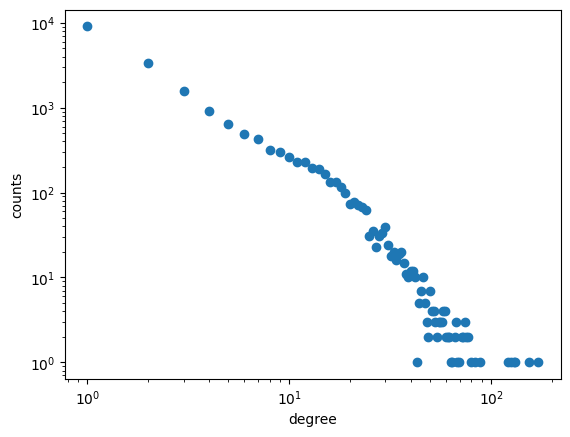

In [11]:
# 両対数グラフ
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.scatter(*np.unique(degree_sequence, return_counts=True))
plt.xlabel("degree")
plt.ylabel("counts")

plt.xscale("log")
plt.yscale("log")

## 2つのノードの関係

最短経路とその長さを探索するアルゴリズムとしては、ダイクストラ法が有名です

In [12]:
# 最短経路
print("ノード0からノード1への最短経路: ", nx.shortest_path(G, source=0, target=1, method="dijkstra"))

# 全ての最短経路
print("ノード0からノード1への全最短経路: ", [path for path in nx.all_shortest_paths(G, source=0, target=1)])

ノード0からノード1への最短経路:  [0, 1544, 2110, 7780, 5966, 2943, 1]
ノード0からノード1への全最短経路:  [[0, 1544, 2110, 7780, 5966, 2943, 1], [0, 6092, 7191, 15864, 13705, 8359, 1], [0, 6092, 16772, 11449, 10051, 8359, 1], [0, 14442, 8372, 6039, 10487, 8359, 1]]


## ネットワークの全体の特徴量

In [13]:
# 局所クラスタ係数平均
print("局所クラスタ係数の平均値: ", np.mean(list(local_clustering.values())))

# 大域的クラスタ係数
print("大域的クラスタ係数: ", nx.transitivity(G))

局所クラスタ係数の平均値:  0.060175209437523615
大域的クラスタ係数:  0.0537076280274887


In [14]:
# 次数相関
print("次数相関: ", nx.degree_pearson_correlation_coefficient(G))

次数相関:  -0.04364031570334542
